In [2]:
data_path = "C:/Users/arwin/Documents/dev/APS360-PROJECT/data/gtzan/genre_specs"

In [3]:
import torch
import torchvision.models as models
import torch.nn as nn
from torchsummary import summary

import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch.optim as optim
import numpy as np


Data Loader and Splits

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dirs, transform=None):
        """
        Args:
            img_dirs (dict): Dictionary with keys 'hit' and 'miss' and their respective image directory paths.
            transform (callable, optional): Optional transform to be applied on a sample.
        """

        label_to_idx = {
            'blues': 0,
            'classical': 1,
            'country': 2,
            'disco': 3,
            'hiphop': 4,
            'jazz': 5,
            'metal': 6,
            'pop': 7,
            'reggae': 8,
            'rock': 9,
        }

        self.img_labels = []
        self.img_files = []
        for label, dir_path in img_dirs.items():
            for file in os.listdir(dir_path):
                if file.endswith('.png'):
                    self.img_files.append(os.path.join(dir_path, file))
                    self.img_labels.append(label_to_idx[label])
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float) 


In [5]:

transform = transforms.Compose([
    # transforms.Resize((224, 224)),  
    transforms.ToTensor(),
])

img_dirs = {
    'blues': data_path + '/blues',
    'classical': data_path + '/classical',
    'country': data_path + '/country',
    'disco': data_path + '/disco',
    'hiphop': data_path + '/hiphop',
    'jazz': data_path + '/jazz',
    'metal': data_path + '/metal',
    'pop': data_path + '/pop',
    'reggae': data_path + '/reggae',
    'rock': data_path + '/rock',
}

# Initialize your dataset
dataset = CustomImageDataset(img_dirs=img_dirs, transform=transform)


In [6]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size + test_size])
val_dataset, test_dataset = torch.utils.data.random_split(val_test_dataset, [val_size, test_size])


In [7]:

class BigModel(nn.Module):
  def  __init__(self):
    super(BigModel, self).__init__()
    # CNN
    resnet18 = models.resnet18(pretrained=True)
    self.features = nn.Sequential(*(list(resnet18.children())[:-2])) # I removed the last two layers of resnet and replaced them with the ones said in the paper
    self.features.add_module("pool", nn.AdaptiveMaxPool2d((1,1)))

    self.fc1_cnn = nn.Linear(512, 256)
    self.dropout_cnn = nn.Dropout(p = 0.5)
    self.batch_norm_cnn = nn.BatchNorm1d(256)
    
    # RNN
    self.bi_gru = nn.GRU(input_size=672, hidden_size = 256, num_layers =1, batch_first=True, bidirectional=True) # I dont know what the size of the input to the bi-gru is supposed to be
    self.fc_gru = nn.Linear(512, 256)
    
    # FC LAYERS
    self.dropout = nn.Dropout(p = 0.5)
    # self.fc = nn.Linear(512, 1)
    self.fc = nn.Linear(512, 10) # becuase 10 genre classes
    # self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    # CNN
    # print(f"Shape before ResNet features: {x.shape}")  # Debug statement 1
    x1 = self.features(x)
    # print(f"Shape after ResNet features: {x1.shape}")  # Debug statement 1
    x1 = torch.flatten(x1, 1)
    # print(f"Shape after flattening: {x1.shape}")  # Debug statement 2
    x1 = self.fc1_cnn(x1)
    x1 = self.dropout_cnn(x1)
    x1 = self.batch_norm_cnn(x1)
    
    # Bi-GRU
    batch_size, channels, height, width = x.shape
    x2 = x.view(batch_size, height, -1)
    # print(f"Shape before Bi-GRU: {x2.shape}")  # Debug statement 4
    x2, _ = self.bi_gru(x2)
    x2 = torch.cat((x2[:, -1, :256], x2[:, 0, 256:]), dim=1)
    x2 = self.fc_gru(x2)

    # Concat Outputs of each model
    x = torch.cat((x1, x2), -1)
    x = self.dropout(x)
    x = self.fc(x)
    # x = self.sigmoid(x)
    return x

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BigModel().to(device)
summary(model, input_size=(3, 224, 224))

c:\Users\arwin\anaconda3\envs\torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\arwin\anaconda3\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
from torch.optim.lr_scheduler import StepLR

In [27]:
batch_size = 16
weight_decay= 5e-3
learning_rate = 0.005
lr_step_sz = 10
lr_gamma = 0.9
num_epochs = 100

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [28]:
model = BigModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = StepLR(optimizer, lr_step_sz, lr_gamma)

# Lists to keep track of progress
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Accuracy calculation function
def get_accuracy(logits, labels):
    _, preds = torch.max(logits, 1)  
    correct = (preds == labels).float() 
    acc = correct.sum() / len(labels)
    return acc

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    # Training
    iteration = 1
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).long()  

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = get_accuracy(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += acc.item() * inputs.size(0)

        # print(f"Iteration {iteration} complete.")
        iteration += 1 
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()  # Adjust for label dimensions

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            acc = get_accuracy(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += acc.item() * inputs.size(0)
    
    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = val_running_corrects / len(val_loader.dataset)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1}, lr: {scheduler.optimizer.param_groups[0]['lr']:.6f}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    scheduler.step()

# Save training history for plotting
np.savez('training_history.npz', train_losses=train_losses, train_accuracies=train_accuracies, val_losses=val_losses, val_accuracies=val_accuracies)


c:\Users\arwin\anaconda3\envs\torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\arwin\anaconda3\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, lr: 0.005000, Train Loss: 2.9344, Train Acc: 0.1731, Val Loss: 11.2934, Val Acc: 0.2081
Epoch 2, lr: 0.005000, Train Loss: 2.6927, Train Acc: 0.1888, Val Loss: 3.4134, Val Acc: 0.1074
Epoch 3, lr: 0.005000, Train Loss: 2.6825, Train Acc: 0.1874, Val Loss: 3.0432, Val Acc: 0.2148
Epoch 4, lr: 0.005000, Train Loss: 2.4819, Train Acc: 0.2260, Val Loss: 2.8499, Val Acc: 0.1409
Epoch 5, lr: 0.005000, Train Loss: 2.5531, Train Acc: 0.2232, Val Loss: 3.1962, Val Acc: 0.1141
Epoch 6, lr: 0.005000, Train Loss: 2.5456, Train Acc: 0.2117, Val Loss: 2.4287, Val Acc: 0.1409
Epoch 7, lr: 0.005000, Train Loss: 2.5032, Train Acc: 0.2389, Val Loss: 3.1490, Val Acc: 0.1409
Epoch 8, lr: 0.005000, Train Loss: 2.5655, Train Acc: 0.1946, Val Loss: 3.1804, Val Acc: 0.1409
Epoch 9, lr: 0.005000, Train Loss: 2.2964, Train Acc: 0.2318, Val Loss: 5.2967, Val Acc: 0.1879
Epoch 10, lr: 0.005000, Train Loss: 2.4014, Train Acc: 0.2132, Val Loss: 2.1522, Val Acc: 0.2416
Epoch 11, lr: 0.004500, Train Loss: 2.

In [ ]:
   
# Optional: Save model and training history
torch.save(model.state_dict(), f'genre_ensemble_model_batch{batch_size}_lr{learning_rate}_weightdecay{weight_decay}.pth')


Plot Training History

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


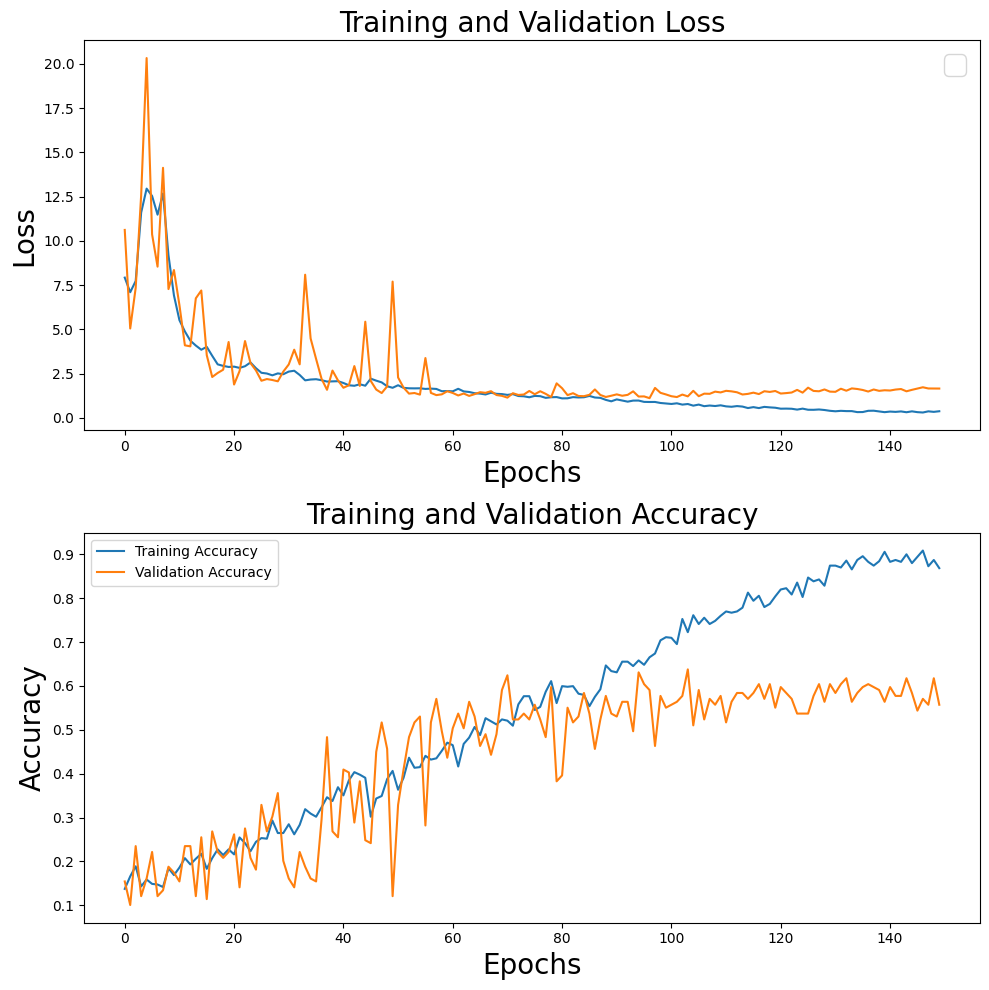

In [23]:
import matplotlib.pyplot as plt
# Load the saved training history

data = np.load('training_history.npz')

# Extracting the training and validation losses and accuracies
train_losses = data['train_losses']
val_losses = data['val_losses']
train_accuracies = data['train_accuracies']
val_accuracies = data['val_accuracies']

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot training and validation losses

# Example for setting text size individually
axs[0].set_xlabel('Epochs', fontsize=20)  # Adjust fontsize as needed
axs[0].set_ylabel('Loss', fontsize=20)  # Adjust fontsize as needed
axs[0].set_title('Training and Validation Loss', fontsize=20)  # Adjust fontsize as needed
axs[0].legend(fontsize=20)

# And similarly for other text elements

axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(val_losses, label='Validation Loss')



# Plot training and validation accuracies
axs[1].plot(train_accuracies, label='Training Accuracy')
axs[1].plot(val_accuracies, label='Validation Accuracy')
axs[1].set_xlabel('Epochs', fontsize=20)
axs[1].set_ylabel('Accuracy', fontsize=20)
axs[1].set_title('Training and Validation Accuracy',fontsize=20)
axs[1].legend()


plt.tight_layout()
plt.show()

Test Accuracy

In [16]:
model.eval()
test_running_loss = 0.0
test_running_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).long()  # Adjust for label dimensions

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = get_accuracy(outputs, labels)

        test_running_loss += loss.item() * inputs.size(0)
        test_running_corrects += acc.item() * inputs.size(0)

test_loss = test_running_loss / len(test_loader.dataset)
test_acc = test_running_corrects / len(test_loader.dataset)

In [17]:
test_acc

0.7947019930706908